# Final Project
By Connor Hanan

## Introduction
At the outset, this project was initially targeted as an analysis of New York State electric vehicle purchases, via the use of rebate information. The main goal was to uncover the factors leading to a higher rebate given to the consumer - sort of as an advisement for future consumers to know what to look for. However, as any project tends to go, the aim shifted as the analysis went deeper. Overall, I was able to determine the factors which most inpacted the size of the rebate - though those brought more questions (specifically about Teslas), as will be seen later in the report.


## Fixing the notebook

I have started to get notebook errors that occur every once in a while, but I can still run the notebook and save it, so I am not quite sure what the issue is. I looked it up, and I think this was supposed to fix it; however, nothing seems to have changed. I'll leave it commented out below for posterity.

The error message is:

>The save operation succeeded, but the notebook does not appear to be valid. The validation error was:

>`Notebook validation failed: Non-unique cell id 'e4482345' detected. Corrected to 'c4655e4e'.:"<UNKNOWN>"`

In [1]:
#import nbformat as nbf
#from glob import glob
#
#import uuid
#def get_cell_id(id_length=8):
#    return uuid.uuid4().hex[:id_length]
#
# your notebook name/keyword
#nb_name = 'team2_project'
#notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))
#
# iterate over notebooks
#for ipath in sorted(notebooks):
#    # load notebook
#    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
#    
#    cell_ids = []
#    for cell in ntbk.cells:
#        cell_ids.append(cell['id'])
#
#    # reset cell ids if there are duplicates
#    if not len(cell_ids) == len(set(cell_ids)): 
#        for cell in ntbk.cells:
#            cell['id'] = get_cell_id()
#
#    nbf.write(ntbk, ipath)

## Importing Packages

Ahead of time, I wanted to import as many modules as I could in order to keep them in the same place. Later on, I think this method fell apart once I started doing apriori mining, but for the most part, the initial ones are below.

`Pandas` and `Numpy` were used for data manipulation, primarily through the use of data frames. Other methods were used for specific situations, though those will be explained in detail when appropriate. `Requests` and `StringIO` were inplemented ahead of time by Professor Caicedo for data importing and loading from a remote server. Finally, `matplotlib` was used for plotting the trends at the end of the analysis.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt 

np.set_printoptions(precision=4)
pd.options.display.max_rows = 20

In [3]:
#Defining the url for the dataset
urlds="https://gitlab.gitlab.svc.cent-su.org/ccaicedo/652public/-/raw/master/fall21/NYSERDA_Electric_Vehicle_Drive_Clean_Rebate_Data__Beginning_2017.csv"
#Access to datasets via URLs is usually easy (see command below) but we have to work around a security issue in our case.

csvdata=requests.get(urlds,verify=False).text  #this will generate a warning but you can proceed

/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gitlab.gitlab.svc.cent-su.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [4]:
data=pd.read_csv(StringIO(csvdata))  #getting the data into a pandas dataframe

## The Data Set

The data set I have selected to use was found on data.gov – specifically, this dataset was uploaded by NYSERDA. It is about 3 MB in size, so it has been uploaded to a public gitlab page for access. Using the `requests` module alongside `StringIO` (from the `io` module), the data can be accessed and read into the notebook. This process ends with the `read_csv()` method from the `pandas` module in order to read the data in as a DataFrame.

Below, the `.head()` and `.info()` methods were used to explore the data. It became quickly apparent that a few different things needed to be cleaned up before meaningful analysis could take place, so those processes take place beneath the initial exploration

In [5]:
data.head()

,Data through Date,Submitted Date,Make,Model,County,ZIP,EV Type,Transaction Type,Annual GHG Emissions Reductions (MT CO2e),Annual Petroleum Reductions (gallons),Rebate Amount (USD)
0,07/09/2021,10/08/2020,Tesla,Model 3,NaN,10549,BEV,Purchase,2.99,592.89,2000.0
1,07/09/2021,10/09/2020,Nissan,LEAF,NaN,14623,BEV,Lease,2.91,592.89,2000.0
2,07/09/2021,10/14/2020,Tesla,Model X,NaN,10956,BEV,Purchase,2.52,592.89,500.0
3,07/09/2021,10/21/2020,Tesla,Model X,NaN,11747,BEV,Lease,2.52,592.89,500.0
4,07/09/2021,10/21/2020,Tesla,Model Y,NaN,10014,BEV,Purchase,3.07,592.89,2000.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43422 entries, 0 to 43421
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Data through Date                          43422 non-null  object 
 1   Submitted Date                             43422 non-null  object 
 2   Make                                       43422 non-null  object 
 3   Model                                      43422 non-null  object 
 4   County                                     43394 non-null  object 
 5   ZIP                                        43422 non-null  int64  
 6   EV Type                                    43422 non-null  object 
 7   Transaction Type                           43421 non-null  object 
 8   Annual GHG Emissions Reductions (MT CO2e)  43422 non-null  float64
 9   Annual Petroleum Reductions (gallons)      43422 non-null  float64
 10  Rebate Amount (USD)   

## Initial Data Cleaning

As can be seen below, the first column (index: 0) is completely useless, as it seems to only reflect the day that the data was first accessed. As such, the entire column could be dropped, since there is no relevant information held in it. The `.drop()` method of `pandas` module was an easy way to accomplish this. Once this was done, I thought it would be of utmost importance to add a new index, so I worked towards it using a couple steps. First, the proper column had to be converted to datetime format using the `.to_datetime()` method (again from the `pandas` module) for time series analysis.

It was becoming a hassle to type the column names, since they had not yet been standardized, so I decided, in the middle of the flow of manipulation, to rename them all to easier names to use. The `.rename()` method was useful in doing this, though typing them all out was somewhat of a pain. In hindsight, I suppose that I could have mapped the names, though I would have had to create a dictionary regardless.

Once processing and manipulation has been made easier (via the renaming of columns - it makes a momumental difference), I was free to return to the proper cleaning of the data. Early analysis was going to be based on time series, so I had one last step to prepare for visualization. `pd.to_datetime()` was my ticket to resetting the index as the actual date. Immediately after, I began running into issues when trying to aggregate the data for plotting, so the __NA__ values all had to be removed. 

There are options, of course, in removing __NA__ values; however, it was a simple choice in this situation. Indeed, one can always interpolate the values using a few different methods; though this data set has so many more valid records (proportionate to those with __NA__ values) that it is much easier to drop the __NA__s. So, this is what was done, using the `.drop_na()` method.

In [7]:
data = data.drop("Data through Date", axis=1)
data.head()

,Submitted Date,Make,Model,County,ZIP,EV Type,Transaction Type,Annual GHG Emissions Reductions (MT CO2e),Annual Petroleum Reductions (gallons),Rebate Amount (USD)
0,10/08/2020,Tesla,Model 3,NaN,10549,BEV,Purchase,2.99,592.89,2000.0
1,10/09/2020,Nissan,LEAF,NaN,14623,BEV,Lease,2.91,592.89,2000.0
2,10/14/2020,Tesla,Model X,NaN,10956,BEV,Purchase,2.52,592.89,500.0
3,10/21/2020,Tesla,Model X,NaN,11747,BEV,Lease,2.52,592.89,500.0
4,10/21/2020,Tesla,Model Y,NaN,10014,BEV,Purchase,3.07,592.89,2000.0


In [8]:
data["Submitted Date"] = pd.to_datetime(data["Submitted Date"])
data.head()

,Submitted Date,Make,Model,County,ZIP,EV Type,Transaction Type,Annual GHG Emissions Reductions (MT CO2e),Annual Petroleum Reductions (gallons),Rebate Amount (USD)
0,2020-10-08,Tesla,Model 3,NaN,10549,BEV,Purchase,2.99,592.89,2000.0
1,2020-10-09,Nissan,LEAF,NaN,14623,BEV,Lease,2.91,592.89,2000.0
2,2020-10-14,Tesla,Model X,NaN,10956,BEV,Purchase,2.52,592.89,500.0
3,2020-10-21,Tesla,Model X,NaN,11747,BEV,Lease,2.52,592.89,500.0
4,2020-10-21,Tesla,Model Y,NaN,10014,BEV,Purchase,3.07,592.89,2000.0


In [9]:
data.rename(columns={
    "Submitted Date":"submit_date",
    "Make":"make",
    "Model":"model",
    "County":"county",
    "ZIP":"zip",
    "EV Type":"ev_type",
    "Transaction Type":"transaction_type",
    "Annual GHG Emissions Reductions (MT CO2e)":"ghg_redux_mtco2e_annual",
    "Annual Petroleum Reductions (gallons)":"petroleum_redux_gallons_annual",
    "Rebate Amount (USD)":"rebate_amt_usd"
}, inplace = True)
data.head()

,submit_date,make,model,county,zip,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
0,2020-10-08,Tesla,Model 3,NaN,10549,BEV,Purchase,2.99,592.89,2000.0
1,2020-10-09,Nissan,LEAF,NaN,14623,BEV,Lease,2.91,592.89,2000.0
2,2020-10-14,Tesla,Model X,NaN,10956,BEV,Purchase,2.52,592.89,500.0
3,2020-10-21,Tesla,Model X,NaN,11747,BEV,Lease,2.52,592.89,500.0
4,2020-10-21,Tesla,Model Y,NaN,10014,BEV,Purchase,3.07,592.89,2000.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43422 entries, 0 to 43421
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   submit_date                     43422 non-null  datetime64[ns]
 1   make                            43422 non-null  object        
 2   model                           43422 non-null  object        
 3   county                          43394 non-null  object        
 4   zip                             43422 non-null  int64         
 5   ev_type                         43422 non-null  object        
 6   transaction_type                43421 non-null  object        
 7   ghg_redux_mtco2e_annual         43422 non-null  float64       
 8   petroleum_redux_gallons_annual  43422 non-null  float64       
 9   rebate_amt_usd                  43264 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 3.

In [11]:
ev_data = data.set_index("submit_date")
ev_data.head()

,make,model,county,zip,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
submit_date,,,,,,,,,
2020-10-08,Tesla,Model 3,NaN,10549,BEV,Purchase,2.99,592.89,2000.0
2020-10-09,Nissan,LEAF,NaN,14623,BEV,Lease,2.91,592.89,2000.0
2020-10-14,Tesla,Model X,NaN,10956,BEV,Purchase,2.52,592.89,500.0
2020-10-21,Tesla,Model X,NaN,11747,BEV,Lease,2.52,592.89,500.0
2020-10-21,Tesla,Model Y,NaN,10014,BEV,Purchase,3.07,592.89,2000.0


In [12]:
ev_data.dropna(inplace=True)

## Initial Plotting for Analysis

Below are the first primitive attempts at trying to figure out if there is an overall trend. Naturally, these are very simple attempts, since I was only trying to decipher high level trends. The easy way to do this was using `matplotlib` and `pyplot` to plot simple rolling trends. First, the date had to be resampled, using the `.resample()` method. Selecting month as the interval will help to reduce the noise of the plot, allowing for easier analysis.

This plot was still slightly too specific for my taste, so a rolling mean `.rolling().mean()` was applied in order to smooth out the plot. The resulting plot did not create many insights, other than the general trend is that total amount of rebates has increased over time, with a recent drop off for the COVID-19 pandemic.

In [13]:
monthly_rebate_sum = ev_data.rebate_amt_usd.resample("M").sum()
monthly_rebate_sum.sort_index(inplace=True)
monthly_rebate_sum.head()

submit_date
2017-03-31     41100.0
2017-04-30    448600.0
2017-05-31    521700.0
2017-06-30    571700.0
2017-07-31    513600.0
Freq: M, Name: rebate_amt_usd, dtype: float64

<AxesSubplot:xlabel='submit_date'>

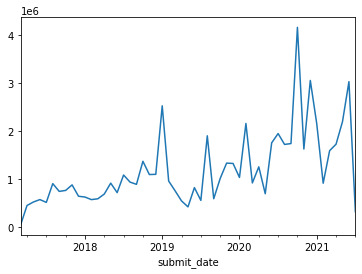

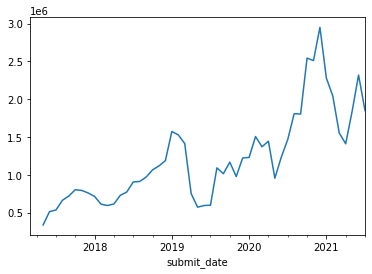

In [14]:
plt.figure()
monthly_rebate_sum.plot()
plt.figure()
monthly_rebate_sum.rolling(3).mean().plot()

## Association Rules Mining Initialization

Association rules mining, otherwise known as frequent pattern analysis, was the method chosen for achieving the first of the goals: determine which factors are most likely to result in a maximum rebate ($2000) to the consumer. This strategy employs the `apriori` algorithm, which is a machine learning tool designed to consider all possibilities of transactions, then whittle down the outcomes from there. It really is a powerful algorithm, because as soon as it finds one element which does not meet the given criteria, it will prune that element and any child elements of it. The child elements will inherently be mathematically worse than the parent element, since it will be "diluted" with other factors. 

In order to prepare for association rules mining, I had to prep the data ahead of time. First, I had to install and import `mlxtend`, a module designed to _extend_ the _machine learning_ capabilities of the python language. I chose to revert to the base import of data in the dataframe `data` such that there will be no potential for messing up the analysis with my previous cleaning. As such, I had to repeat some of the steps, such as using the `.dropna()` and `.reset_index()` methods to try to revert the data into a more usable state.

In [15]:
%pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import re

     |████████████████████████████████| 1.3 MB 6.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
cluster_data = data.dropna()

In [17]:
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43235 entries, 29 to 43421
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   submit_date                     43235 non-null  datetime64[ns]
 1   make                            43235 non-null  object        
 2   model                           43235 non-null  object        
 3   county                          43235 non-null  object        
 4   zip                             43235 non-null  int64         
 5   ev_type                         43235 non-null  object        
 6   transaction_type                43235 non-null  object        
 7   ghg_redux_mtco2e_annual         43235 non-null  float64       
 8   petroleum_redux_gallons_annual  43235 non-null  float64       
 9   rebate_amt_usd                  43235 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 3

In [18]:
cluster_data = cluster_data.reset_index()

In [19]:
cluster_data.drop("index", axis=1, inplace=True)

In [20]:
cluster_data.head()

,submit_date,make,model,county,zip,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
0,2017-03-30,Toyota,Prius Prime,Albany,12211,PHEV,Purchase,3.03,440.11,1100.0
1,2017-04-03,Kia,Soul EV,Albany,12205,BEV,Lease,2.76,592.89,1700.0
2,2017-04-08,Toyota,Prius Prime,Albany,12110,PHEV,Purchase,3.03,440.11,1100.0
3,2017-04-10,Chevrolet,Volt,Albany,12203,PHEV,Purchase,2.70,525.03,1700.0
4,2017-04-10,Chevrolet,Volt,Albany,12208,PHEV,Purchase,2.70,525.03,1700.0


## Association Rules Mining Preparation

Once the data had been re-initialized, it was time to actually prepare the dataframe for the apriori algorithm. The first step was to normalize the numerical data, using the `.MinMaxScaler()` method from `sklearn`, a popular machine learning toolkit for python known as scikit-learn. This would turn out to be unneeded, but at this time, I was under the impression that it was neccessary. Further cleaning included dropping certain columns that were extra information, such as county adn zip code. They were decidied to be extraneous purely because that kind of location data could be found already in the city column. If it had turned out that those were important, it would be easy enough to re-add them back in; however, in order to optimize the algorithm as much as possible the first time through they were left out.

Dates became another tricky use case, for a few reasons. First, of course, they may prove very instrumental to the analysis of the data, since there may be holiday rebate deals or trends that would skew the data. However, when in datetime format, the apriori algorithm would treat each one as an individual category. Ususally this would be fine, if there were hundreds of records for each day -- though this was not the case. Due to the limited amount of records per day, considering each one individually in the algorithm would essentially skew them into oblivion. Each one has so little amount of weight to it (in terms of records) that it would actually be detrimental to the algorithm to consider them. As such, it was decided that breaking up each date into its various date-parts would allow for greater analysis. The `.year()` and `.month()` methods were useful in extracting the specific parts required for each of the new columns (separating by days became too granular of a separation, so each date was floored to the month and year).

The mlxtend implementation of the apriori algorithm requires one hot encoding of the data, which means that every value in each column has to be a 1 or a 0 to represent `TRUE` or `FALSE`, the two states of a boolean expression. To get there, however, a few steps needed to be taken first. Of course, to convert the table into one hot encoding, each and every column has to be converted to the `categorical` type. This is similar to a `factor` data type in other languages, where each string or value is assigned a numeral, for ease of categorization and removal of text purposes. After all the data was finally in the proper format, and ready to go, it was time to convert everything to one hot encoded. The `.get_dummies()` method fromt the Pandas package proved immensely useful for this. It automatically created new columns for each category of every column, expanding the dataframe from roughly 7 columns to upwards of 100.

In [21]:
#%pip install sklearn
from sklearn import preprocessing as pre

normal_data = cluster_data.copy()
scaler = pre.MinMaxScaler()
normal_data[["ghg_redux_mtco2e_annual", "petroleum_redux_gallons_annual"]] = scaler.fit_transform(normal_data[["ghg_redux_mtco2e_annual", "petroleum_redux_gallons_annual"]])

In [22]:
normal_data.head()

,submit_date,make,model,county,zip,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
0,2017-03-30,Toyota,Prius Prime,Albany,12211,PHEV,Purchase,0.941788,0.745367,1100.0
1,2017-04-03,Kia,Soul EV,Albany,12205,BEV,Lease,0.885655,1.000000,1700.0
2,2017-04-08,Toyota,Prius Prime,Albany,12110,PHEV,Purchase,0.941788,0.745367,1100.0
3,2017-04-10,Chevrolet,Volt,Albany,12203,PHEV,Purchase,0.873181,0.886900,1700.0
4,2017-04-10,Chevrolet,Volt,Albany,12208,PHEV,Purchase,0.873181,0.886900,1700.0


In [23]:
normal_data.drop("county", axis=1, inplace=True)
normal_data.drop("zip", axis=1, inplace=True)

In [24]:
normal_data.head()

,submit_date,make,model,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
0,2017-03-30,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0
1,2017-04-03,Kia,Soul EV,BEV,Lease,0.885655,1.000000,1700.0
2,2017-04-08,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0
3,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0
4,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0


In [25]:
normal_data.submit_date = pd.to_datetime(normal_data.submit_date)
normal_data["year"] = pd.DatetimeIndex(normal_data.submit_date).year
normal_data["month"] = pd.DatetimeIndex(normal_data.submit_date).month
normal_data.info()
normal_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43235 entries, 0 to 43234
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   submit_date                     43235 non-null  datetime64[ns]
 1   make                            43235 non-null  object        
 2   model                           43235 non-null  object        
 3   ev_type                         43235 non-null  object        
 4   transaction_type                43235 non-null  object        
 5   ghg_redux_mtco2e_annual         43235 non-null  float64       
 6   petroleum_redux_gallons_annual  43235 non-null  float64       
 7   rebate_amt_usd                  43235 non-null  float64       
 8   year                            43235 non-null  int64         
 9   month                           43235 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 3.

,submit_date,make,model,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd,year,month
0,2017-03-30,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0,2017,3
1,2017-04-03,Kia,Soul EV,BEV,Lease,0.885655,1.000000,1700.0,2017,4
2,2017-04-08,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0,2017,4
3,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0,2017,4
4,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0,2017,4


In [26]:
normal_data.drop("submit_date", axis=1, inplace=True)

In [27]:
normal_data.rebate_amt_usd = normal_data.rebate_amt_usd.astype("int")

In [28]:
normal_data.make = normal_data.make.astype("category")
normal_data.model = normal_data.model.astype("category")
normal_data.ev_type = normal_data.ev_type.astype("category")
normal_data.transaction_type = normal_data.transaction_type.astype("category")
normal_data.month = normal_data.month.astype("category")
normal_data.year = normal_data.year.astype("category")
normal_data.rebate_amt_usd = normal_data.rebate_amt_usd.astype("category")

In [29]:
one_hot = pd.get_dummies(normal_data, 
                         columns=["make", "model", "ev_type", "transaction_type", "year", "month", "rebate_amt_usd"])

In [30]:
one_hot.head()

,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,make_Audi,make_BMW,make_Chevrolet,make_Chrysler,make_Ford,make_Honda,make_Hyundai,make_Jaguar,...,month_8,month_9,month_10,month_11,month_12,rebate_amt_usd_500,rebate_amt_usd_1000,rebate_amt_usd_1100,rebate_amt_usd_1700,rebate_amt_usd_2000
0,0.941788,0.745367,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.885655,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.941788,0.745367,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.873181,0.886900,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.873181,0.886900,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
one_hot.dtypes

ghg_redux_mtco2e_annual           float64
petroleum_redux_gallons_annual    float64
make_Audi                           uint8
make_BMW                            uint8
make_Chevrolet                      uint8
                                   ...   
rebate_amt_usd_500                  uint8
rebate_amt_usd_1000                 uint8
rebate_amt_usd_1100                 uint8
rebate_amt_usd_1700                 uint8
rebate_amt_usd_2000                 uint8
Length: 112, dtype: object

## Association Mining
Now that the data has been one-hot encoded, it is finally time for the actual algorithm to be run on the dataframe. An oversight, as previously mentioned, was the uselessnes of the ghg and petroleum reduction columns, so they had to be dropped prior to the algorithm's processing. It turns out that I could have binned the data in order to convert the numerical type into a categorical one; however, it would not have mattered too much, since each statistic is bound to the car. In other words, since the make and model categories remain, the ghg and petroleum statistics are in effect still considered when processing the data.

Once that has been all cleared up, the frequent itemsets can be generated using the apriori algortihm. The algorithm's method takes a few parameters, such as minimum support. Support is one of the many metrics that the apriori algorithm judges each transaction by. A few important terms are explained below: 

>Transaction: one row indicating which categories are true and which are false <br>

> {X} => {Y}: X are the antecedents (factors) which cause Y, the consequent (result) <br>

>Support: a measure of how many transactions contain both X and Y <br>

>Confidence: a measure of how often Y appears in transactions with X <br>

>Lift: a measure of correlation between the antecedents and consequents (greater lift means the relationship is more meaningful) <br>

When running the algorithm, a minimum support level has been defined as 0.07. This means that the combination of antecedents and consequents must show up in at least 7% of the overall dataset. The frequent itemsets are then passed through the `association_rules()"` method, which actually generates the rules from all the various statistics that are measured. In this method, the `metric` parameter is passed as lift, indicating that the results should be sorted by lift. 

At this point, all the rules have been generated, but the consequents were all over the place. For a useful analysis, I wanted to set only the maximum rebate as the consequent, so that the antecedents would demonstrate what factors were important leading in to it. A quick, albeit manual, search of the unique consequents revealed the exact syntax of the consequent to be `rebate_amt_usd_2000`, which made it all the more simple to subset the rules where that condition was met.

There were still too many rules to sort through, so a little more refinement was in order. Using more subsetting, the support threshold was able to be increased to a pretty secure 10%, and the confidence to a respectable 75%. These limitations helped to clear out a lot of the noise in the ruleset, allowing the strongest and most important ones to remain. A last use of the `.sort_values()` method reordered the remaining rules by their lift value, letting those with the highest correlation (and therefore the strongest relationship) to float their way to the top of the list.

In [32]:
one_hot.drop("ghg_redux_mtco2e_annual", axis=1, inplace=True)
one_hot.drop("petroleum_redux_gallons_annual", axis=1, inplace=True)

In [33]:
frequent_itemsets = apriori(one_hot, min_support=0.07, use_colnames=True)

In [34]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(make_Tesla),(model_Model 3),0.313658,0.170371,0.170371,0.543175,3.188187,0.116933,1.816077
1,(model_Model 3),(make_Tesla),0.170371,0.313658,0.170371,1.000000,3.188187,0.116933,inf
2,(model_Model Y),(make_Tesla),0.079588,0.313658,0.079588,1.000000,3.188187,0.054625,inf
3,(make_Tesla),(model_Model Y),0.313658,0.079588,0.079588,0.253742,3.188187,0.054625,1.233370
4,(ev_type_BEV),(make_Tesla),0.472927,0.313658,0.313658,0.663227,2.114491,0.165321,2.037995


In [35]:
rules.consequents.unique()

array([frozenset({'model_Model 3'}), frozenset({'make_Tesla'}),
       frozenset({'model_Model Y'}), frozenset({'ev_type_BEV'}),
       frozenset({'transaction_type_Purchase'}), frozenset({'year_2019'}),
       frozenset({'year_2020'}), frozenset({'rebate_amt_usd_2000'}),
       frozenset({'make_Toyota'}), frozenset({'model_Prius Prime'}),
       frozenset({'ev_type_PHEV'}), frozenset({'year_2021'}),
       frozenset({'rebate_amt_usd_1100'}),
       frozenset({'rebate_amt_usd_500'}),
       frozenset({'transaction_type_Lease'}), frozenset({'year_2017'}),
       frozenset({'year_2018'}), frozenset({'rebate_amt_usd_1700'}),
       frozenset({'make_Tesla', 'model_Model 3'}),
       frozenset({'ev_type_BEV', 'model_Model 3'}),
       frozenset({'ev_type_BEV', 'make_Tesla'}),
       frozenset({'transaction_type_Purchase', 'model_Model 3'}),
       frozenset({'make_Tesla', 'transaction_type_Purchase'}),
       frozenset({'year_2020', 'model_Model 3'}),
       frozenset({'year_2020', 'make_Te

In [36]:
max_rebate_rules = rules[rules['consequents'] == {"rebate_amt_usd_2000"}]

In [37]:
best_rules = max_rebate_rules[(max_rebate_rules["support"] > 0.1) & (max_rebate_rules["confidence"] > 0.75)]

In [38]:
best_rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
385,"(ev_type_BEV, make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.170371,0.382792,0.168197,0.987239,2.579049,0.102980,48.365491
107,"(make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.170371,0.382792,0.168197,0.987239,2.579049,0.102980,48.365491
227,"(ev_type_BEV, model_Model 3)",(rebate_amt_usd_2000),0.170371,0.382792,0.168197,0.987239,2.579049,0.102980,48.365491
31,(model_Model 3),(rebate_amt_usd_2000),0.170371,0.382792,0.168197,0.987239,2.579049,0.102980,48.365491
623,"(ev_type_BEV, make_Tesla, transaction_type_Pur...",(rebate_amt_usd_2000),0.139979,0.382792,0.137805,0.984468,2.571811,0.084222,39.737708


## Checking in with the IRS for federal rebates
It seems like Tesla Model 3 is the most common way people are getting the full \$2000 rebate in NY State, since it is included in just about every single one of the top rules. However, there may be other reasons why consumers are looking at the Model 3. It turns out that there was a federal rebate almost four times as large for Tesla Model 3s, which has since been phased out. The official text of the phasing out process is detailed below:

>Taxpayers may claim the full amount of the credit up the end of the first quarter after the quarter in which the manufacturer records its sale of the 200,000th qualified vehicle. For the second and third calendar quarters, taxpayers may claim 50\% of the credit. For the fourth and fifth calendar quarters, taxpayers may claim 25\% of the credit. No credit is allowed after the fifth quarter. Section 4.07 of Notice 2009-89 provides that a vehicle is not “acquired” before the date on which title passes under state law. <br>
>https://www.irs.gov/businesses/irc-30d-new-qualified-plug-in-electric-drive-motor-vehicle-credit

Phasing out the Tesla rebates after 1/1/2020 might have disincentivized people from buying them, so it seems the natural next step is to compare the two time periods. As such, I have re-initialized the data, and split it up into two dataframes using subsetting. After this, the same methods and processes were copied from above to generate the association rules for each time period in order to determine if there is a difference in the outcome -- or, at the very least, a decrease in the prevalence of the Tesla Model 3 amongst the top rules.

In [39]:
normal_data = cluster_data.copy()
scaler = pre.MinMaxScaler()
normal_data[["ghg_redux_mtco2e_annual", "petroleum_redux_gallons_annual"]] = scaler.fit_transform(normal_data[["ghg_redux_mtco2e_annual", "petroleum_redux_gallons_annual"]])

In [40]:
normal_data.head()

,submit_date,make,model,county,zip,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
0,2017-03-30,Toyota,Prius Prime,Albany,12211,PHEV,Purchase,0.941788,0.745367,1100.0
1,2017-04-03,Kia,Soul EV,Albany,12205,BEV,Lease,0.885655,1.000000,1700.0
2,2017-04-08,Toyota,Prius Prime,Albany,12110,PHEV,Purchase,0.941788,0.745367,1100.0
3,2017-04-10,Chevrolet,Volt,Albany,12203,PHEV,Purchase,0.873181,0.886900,1700.0
4,2017-04-10,Chevrolet,Volt,Albany,12208,PHEV,Purchase,0.873181,0.886900,1700.0


In [41]:
normal_data.drop("county", axis=1, inplace=True)
normal_data.drop("zip", axis=1, inplace=True)

In [42]:
normal_data.head()

,submit_date,make,model,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd
0,2017-03-30,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0
1,2017-04-03,Kia,Soul EV,BEV,Lease,0.885655,1.000000,1700.0
2,2017-04-08,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0
3,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0
4,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0


In [43]:
normal_data.submit_date = pd.to_datetime(normal_data.submit_date)
normal_data["year"] = pd.DatetimeIndex(normal_data.submit_date).year
normal_data["month"] = pd.DatetimeIndex(normal_data.submit_date).month
normal_data.info()
normal_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43235 entries, 0 to 43234
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   submit_date                     43235 non-null  datetime64[ns]
 1   make                            43235 non-null  object        
 2   model                           43235 non-null  object        
 3   ev_type                         43235 non-null  object        
 4   transaction_type                43235 non-null  object        
 5   ghg_redux_mtco2e_annual         43235 non-null  float64       
 6   petroleum_redux_gallons_annual  43235 non-null  float64       
 7   rebate_amt_usd                  43235 non-null  float64       
 8   year                            43235 non-null  int64         
 9   month                           43235 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 3.

,submit_date,make,model,ev_type,transaction_type,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,rebate_amt_usd,year,month
0,2017-03-30,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0,2017,3
1,2017-04-03,Kia,Soul EV,BEV,Lease,0.885655,1.000000,1700.0,2017,4
2,2017-04-08,Toyota,Prius Prime,PHEV,Purchase,0.941788,0.745367,1100.0,2017,4
3,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0,2017,4
4,2017-04-10,Chevrolet,Volt,PHEV,Purchase,0.873181,0.886900,1700.0,2017,4


In [44]:
normal_data.drop("submit_date", axis=1, inplace=True)

In [45]:
normal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43235 entries, 0 to 43234
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   make                            43235 non-null  object 
 1   model                           43235 non-null  object 
 2   ev_type                         43235 non-null  object 
 3   transaction_type                43235 non-null  object 
 4   ghg_redux_mtco2e_annual         43235 non-null  float64
 5   petroleum_redux_gallons_annual  43235 non-null  float64
 6   rebate_amt_usd                  43235 non-null  float64
 7   year                            43235 non-null  int64  
 8   month                           43235 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.0+ MB


### Splitting between the two

In [46]:
fed_tax = normal_data[normal_data.year < 2020]

In [47]:
no_fed_tax = normal_data[normal_data.year >= 2020]

### Federal Tax Era
Beginning to, but not including, 2020

In [48]:
fed_tax.rebate_amt_usd = fed_tax.rebate_amt_usd.astype("int")

fed_tax.make = fed_tax.make.astype("category")
fed_tax.model = fed_tax.model.astype("category")
fed_tax.ev_type = fed_tax.ev_type.astype("category")
fed_tax.transaction_type = fed_tax.transaction_type.astype("category")
fed_tax.month = fed_tax.month.astype("category")
fed_tax.year = fed_tax.year.astype("category")
fed_tax.rebate_amt_usd = fed_tax.rebate_amt_usd.astype("category")

one_hot_fed = pd.get_dummies(fed_tax, columns=["make", "model", "ev_type", "transaction_type", "year", "month", "rebate_amt_usd"])

one_hot_fed.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,make_Audi,make_BMW,make_Chevrolet,make_Chrysler,make_Ford,make_Honda,make_Hyundai,make_Jaguar,...,month_7,month_8,month_9,month_10,month_11,month_12,rebate_amt_usd_500,rebate_amt_usd_1100,rebate_amt_usd_1700,rebate_amt_usd_2000
0,0.941788,0.745367,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.885655,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.941788,0.745367,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.873181,0.886900,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.873181,0.886900,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
one_hot_fed.drop("ghg_redux_mtco2e_annual", axis=1, inplace=True)
one_hot_fed.drop("petroleum_redux_gallons_annual", axis=1, inplace=True)

In [50]:
frequent_itemsets = apriori(one_hot_fed, min_support=0.07, use_colnames=True)

In [51]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(model_Volt),(make_Chevrolet),0.078484,0.142816,0.078484,1.000000,7.002015,0.067275,inf
1,(make_Chevrolet),(model_Volt),0.142816,0.078484,0.078484,0.549547,7.002015,0.067275,2.045752
2,(transaction_type_Lease),(make_Chevrolet),0.421156,0.142816,0.077141,0.183164,1.282520,0.016993,1.049396
3,(make_Chevrolet),(transaction_type_Lease),0.142816,0.421156,0.077141,0.540141,1.282520,0.016993,1.258742
4,(make_Chevrolet),(rebate_amt_usd_1700),0.142816,0.220964,0.077908,0.545516,2.468796,0.046351,1.714109


In [52]:
rules.consequents.unique()

array([frozenset({'make_Chevrolet'}), frozenset({'model_Volt'}),
       frozenset({'transaction_type_Lease'}),
       frozenset({'rebate_amt_usd_1700'}), frozenset({'make_Ford'}),
       frozenset({'model_Fusion Energi'}), frozenset({'ev_type_PHEV'}),
       frozenset({'rebate_amt_usd_1100'}), frozenset({'model_Clarity'}),
       frozenset({'make_Honda'}), frozenset({'year_2018'}),
       frozenset({'model_Model 3'}), frozenset({'make_Tesla'}),
       frozenset({'ev_type_BEV'}),
       frozenset({'transaction_type_Purchase'}), frozenset({'year_2019'}),
       frozenset({'rebate_amt_usd_2000'}), frozenset({'make_Toyota'}),
       frozenset({'model_Prius Prime'}), frozenset({'year_2017'}),
       frozenset({'month_10'}), frozenset({'month_1'}),
       frozenset({'month_8'}),
       frozenset({'ev_type_PHEV', 'make_Chevrolet'}),
       frozenset({'model_Volt', 'ev_type_PHEV'}),
       frozenset({'model_Volt', 'make_Chevrolet'}),
       frozenset({'make_Chevrolet', 'rebate_amt_usd_1700'}),

In [53]:
max_rebate_rules = rules[rules['consequents'] == {"rebate_amt_usd_2000"}]

In [54]:
best_rules_fed = max_rebate_rules[(max_rebate_rules["support"] > 0.1) & (max_rebate_rules["confidence"] > 0.75)]

In [55]:
best_rules_fed.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,(model_Model 3),(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
419,"(ev_type_BEV, model_Model 3)",(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
773,"(ev_type_BEV, make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
245,"(make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
437,"(year_2019, model_Model 3)",(rebate_amt_usd_2000),0.129048,0.2651,0.124874,0.967658,3.650168,0.090664,22.722784


## Analysis of the Federal Tax Era
As expected, the Tesla Model 3 is still extremely prevalent in the federal tax era, making up just about every single one of the top rules (and actually being the single highest rule on its own). There is still very high lift, confidence, and support, making all these rules extremely strong and important in determining the maximum rebate. Now, it is time to examine the post-federal tax era (1/1/20 - present).

### NON-Federal Tax Era
Jan. 1 2020 to Present

In [56]:
no_fed_tax.rebate_amt_usd = no_fed_tax.rebate_amt_usd.astype("int")

no_fed_tax.make = no_fed_tax.make.astype("category")
no_fed_tax.model = no_fed_tax.model.astype("category")
no_fed_tax.ev_type = no_fed_tax.ev_type.astype("category")
no_fed_tax.transaction_type = no_fed_tax.transaction_type.astype("category")
no_fed_tax.month = no_fed_tax.month.astype("category")
no_fed_tax.year = no_fed_tax.year.astype("category")
no_fed_tax.rebate_amt_usd = no_fed_tax.rebate_amt_usd.astype("category")

one_hot_no_fed = pd.get_dummies(no_fed_tax, columns=["make", "model", "ev_type", "transaction_type", "year", "month", "rebate_amt_usd"])

one_hot_no_fed.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,ghg_redux_mtco2e_annual,petroleum_redux_gallons_annual,make_Audi,make_BMW,make_Chevrolet,make_Chrysler,make_Ford,make_Honda,make_Hyundai,make_Jaguar,...,month_8,month_9,month_10,month_11,month_12,rebate_amt_usd_500,rebate_amt_usd_1000,rebate_amt_usd_1100,rebate_amt_usd_1700,rebate_amt_usd_2000
634,0.916840,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
635,0.916840,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
636,0.916840,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
637,0.671518,0.514283,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
638,0.941788,0.745367,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [57]:
one_hot_no_fed.drop("ghg_redux_mtco2e_annual", axis=1, inplace=True)
one_hot_no_fed.drop("petroleum_redux_gallons_annual", axis=1, inplace=True)

In [58]:
frequent_itemsets = apriori(one_hot_no_fed, min_support=0.07, use_colnames=True)

In [59]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(transaction_type_Lease),(make_Hyundai),0.383207,0.117642,0.103573,0.27028,2.297480,0.058492,1.209173
1,(make_Hyundai),(transaction_type_Lease),0.117642,0.383207,0.103573,0.88041,2.297480,0.058492,5.157566
2,(make_Tesla),(model_Model 3),0.420858,0.191246,0.191246,0.45442,2.376101,0.110759,1.482375
3,(model_Model 3),(make_Tesla),0.191246,0.420858,0.191246,1.00000,2.376101,0.110759,inf
4,(model_Model Y),(make_Tesla),0.153685,0.420858,0.153685,1.00000,2.376101,0.089005,inf


In [60]:
rules.consequents.unique()

array([frozenset({'make_Hyundai'}), frozenset({'transaction_type_Lease'}),
       frozenset({'model_Model 3'}), frozenset({'make_Tesla'}),
       frozenset({'model_Model Y'}), frozenset({'ev_type_BEV'}),
       frozenset({'transaction_type_Purchase'}), frozenset({'year_2020'}),
       frozenset({'month_10'}), frozenset({'rebate_amt_usd_500'}),
       frozenset({'rebate_amt_usd_2000'}), frozenset({'make_Toyota'}),
       frozenset({'model_Prius Prime'}), frozenset({'model_RAV4 Prime'}),
       frozenset({'ev_type_PHEV'}), frozenset({'year_2021'}),
       frozenset({'rebate_amt_usd_1100'}),
       frozenset({'rebate_amt_usd_1700'}), frozenset({'month_6'}),
       frozenset({'month_12'}),
       frozenset({'make_Tesla', 'model_Model 3'}),
       frozenset({'ev_type_BEV', 'model_Model 3'}),
       frozenset({'ev_type_BEV', 'make_Tesla'}),
       frozenset({'transaction_type_Purchase', 'model_Model 3'}),
       frozenset({'make_Tesla', 'transaction_type_Purchase'}),
       frozenset({'year_

In [61]:
max_rebate_rules = rules[rules['consequents'] == {"rebate_amt_usd_2000"}]

In [62]:
best_rules_no_fed = max_rebate_rules[(max_rebate_rules["support"] > 0.1) & (max_rebate_rules["confidence"] > 0.75)]

In [63]:
best_rules_no_fed.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1016,"(year_2020, transaction_type_Purchase, model_M...",(rebate_amt_usd_2000),0.130549,0.492363,0.130549,1.0,2.031023,0.066272,inf
327,"(ev_type_BEV, model_Model 3)",(rebate_amt_usd_2000),0.191246,0.492363,0.191246,1.0,2.031023,0.097084,inf
599,"(make_Tesla, transaction_type_Purchase, model_...",(rebate_amt_usd_2000),0.144975,0.492363,0.144975,1.0,2.031023,0.073595,inf
569,"(ev_type_BEV, make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.191246,0.492363,0.191246,1.0,2.031023,0.097084,inf
1258,"(year_2020, ev_type_BEV, make_Tesla, model_Mod...",(rebate_amt_usd_2000),0.176686,0.492363,0.176686,1.0,2.031023,0.089692,inf


## Analysis of the Non-Federal Tax Era
Somewhat surprisingly, the Tesla Model 3 was still included in every rule from the non-federal tax era as well. My initial hypothesis was that the lack of an extra rebate would have disincentivized consumers from purchasing the Tesla, since, in relative terms, the car just became a good $7500 more expensive.

## Comparison of the Rules and Further Analysis
Below, the rules of the two periods can be viewed next to one another, with the federal era rules on top and the non-federal era rules immediately below them. It appears that the rules are just as strong before as after the change in the federal tax program in terms of receiving the maximum state rebate. This means that there was no correlation between the state and federal rebate/tax credit programs, since the state is still giving out full rebates for Teslas (even though there is no longer a federal credit).

Even though there might not have been a correlation between the state and federal programs' effect on the purchasing habits of consumers, the rules that were generated were all highly correlated to the state level. It is of note that the federal era had higher lift scores, but both sets of rules scored well over 1, indicating a very strong correlation between the antecedents and consequents.

Tesla Model 3s must just be a popular car amongst consumers at the moment, or are being influenced by a factor other than rebates and tax credits offered. In fact, a quick summation of the two time periods indicates that over two times as many Model 3s were purchased in the state of New York after the Federal Tax Credit era ended, than as it was still going (4138 during the program vs. 9423 after). A quick plot of the purchases over time confirms this realization -- purchases do in fact increase year over year. Note that while 2020 has the largest amount of purchases to that point, 2021 appears underwhelming in terms of purchases. This can be attributed to the fact that the data only included purchases and leases until about half way through the year, making the results incomplete. Even so, there are still quite a few being purchased, and I cannot help but think that the numbers would greatly increase as the end of the year approaches.

In [64]:
best_rules_fed.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,(model_Model 3),(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
419,"(ev_type_BEV, model_Model 3)",(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
773,"(ev_type_BEV, make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
245,"(make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.147949,0.2651,0.143440,0.969520,3.657193,0.104218,24.110989
437,"(year_2019, model_Model 3)",(rebate_amt_usd_2000),0.129048,0.2651,0.124874,0.967658,3.650168,0.090664,22.722784


In [65]:
best_rules_no_fed.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1016,"(year_2020, transaction_type_Purchase, model_M...",(rebate_amt_usd_2000),0.130549,0.492363,0.130549,1.0,2.031023,0.066272,inf
327,"(ev_type_BEV, model_Model 3)",(rebate_amt_usd_2000),0.191246,0.492363,0.191246,1.0,2.031023,0.097084,inf
599,"(make_Tesla, transaction_type_Purchase, model_...",(rebate_amt_usd_2000),0.144975,0.492363,0.144975,1.0,2.031023,0.073595,inf
569,"(ev_type_BEV, make_Tesla, model_Model 3)",(rebate_amt_usd_2000),0.191246,0.492363,0.191246,1.0,2.031023,0.097084,inf
1258,"(year_2020, ev_type_BEV, make_Tesla, model_Mod...",(rebate_amt_usd_2000),0.176686,0.492363,0.176686,1.0,2.031023,0.089692,inf


In [66]:
fed_tax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20845 entries, 0 to 43203
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   make                            20845 non-null  category
 1   model                           20845 non-null  category
 2   ev_type                         20845 non-null  category
 3   transaction_type                20845 non-null  category
 4   ghg_redux_mtco2e_annual         20845 non-null  float64 
 5   petroleum_redux_gallons_annual  20845 non-null  float64 
 6   rebate_amt_usd                  20845 non-null  category
 7   year                            20845 non-null  category
 8   month                           20845 non-null  category
dtypes: category(7), float64(2)
memory usage: 634.1 KB


In [67]:
(fed_tax.make == "Tesla").sum()

4138

In [68]:
(no_fed_tax.make == "Tesla").sum()

9423

#### Plotting the differences

In [69]:
import matplotlib.pyplot as plt
import numpy as np

tesla = normal_data[normal_data.make == "Tesla"]
tesla.year = tesla.year.astype("str")
tesla_grouped = tesla.groupby(["year"]).count()

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


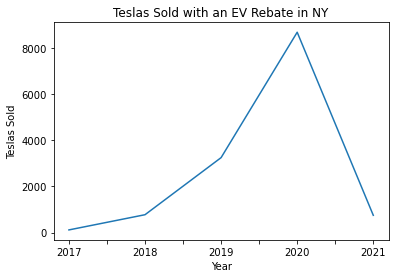

In [70]:
tesla_grouped["model"].plot()

plt.xlabel("Year")
plt.ylabel("Teslas Sold")
plt.title("Teslas Sold with an EV Rebate in NY")
plt.savefig('teslas_sold.png', dpi=300)

## Conclusion
While the result may not have been one that was expected, it was insightful nonetheless. It seems that Teslas, and specifically the Model 3, are the most common way to earn the full rebate in the state of New York. However, it seems that the rebate had little to no effect on whether the consumers were seeking to buy the car for the rebate, as proven by the apparent increase of purchases and leases after the federal tax credit program ended. The end of the program essentially made the vehicles just that that little bit more expensive -- the current price of a base Model 3 is about $45,000, so the both rebates combined would have almost made it 20\% cheaper. Though the availability of a rebate might have had more weight to some consumers than others, it appears that on the whole, New Yorkers were just as excited to purchase a Tesla Model 3 without it.